In [821]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
import math
from mpmath import *
mp.dps = 10 # accuracy
mp.pretty = True

In [822]:
particle_diameter = 1e-6 # m
particle_density = 997 # kg/m^3
particle_cross_section_area = mpf(math.pi*(particle_diameter/2)**2)
particle_volume = mpf(4/3*math.pi*(particle_diameter/2)**3)
particle_mass = mpf(particle_volume*particle_density)
fluid_density = 1.255 # kg/m^3

dynamic_viscosity_air_25C = 1.849e-5
mean_free_path_air_25C = 6.826e-8

reynolds_max = None
reynolds_min = None
speed_max = 0

In [823]:
Re = lambda v: mpf(fluid_density*v*particle_diameter/dynamic_viscosity_air_25C)  #not entirely accurate

# Slip correction factor
C_c = mpf(1 + 2*mean_free_path_air_25C/particle_diameter*(1.257+0.4*mpf(math.e**(-1.1*particle_diameter/(2*mean_free_path_air_25C)))))


def C_d(Re):
    global reynolds_max 
    global reynolds_min
    if reynolds_max is None or Re > reynolds_max:
        reynolds_max = Re
    if reynolds_min is None or Re < reynolds_min:
        reynolds_min = Re
    if Re < 0.1:
        return mpf(24/Re)
    elif Re > 0.1 and Re < 0.2:
        return mpf(24/Re*(1+3/16*Re+9/160*Re**2*log(2*Re)))
    elif Re > 0.2 and Re < 500:
        return mpf(24/Re*(1+0.15*Re**0.686))
    elif Re > 500 and Re < 2e5:
        return 0.44
    reynolds_to_large = True
    raise Exception('Reynolds number to large')
        
def F_drag(v):
    # also add drag force = 0 if velocity is 0
    if particle_diameter < 10e-6:
        return mpf((3*math.pi*dynamic_viscosity_air_25C*v*particle_diameter)/(C_c*(2/particle_diameter)))
    else:
        return mpf(math.pi/8*C_d(Re(v))*fluid_density*particle_diameter**2*v**2)

In [824]:
def euler(xy_n, delta_t, funcs):
    # 2D euler
    x_n = mpf(xy_n[0] + delta_t*funcs[0])
    y_n = mpf(xy_n[1] + delta_t*funcs[1])
    return [x_n, y_n]

#euler1D = lambda y_n, delta_t, func: y_n + delta_t*func

F_g_1 = 1/6*math.pi*particle_density*particle_diameter**3*constants.g
F_g = mpf(particle_mass*constants.g)
F_d_8 = lambda v: (math.pi*C_d(Re(v))*particle_density*particle_diameter**2*v**2)/8
F_d_3 = lambda v: (3*math.pi*dynamic_viscosity_air_25C*particle_diameter*v)/22.7
F_d_wiki = lambda v: 1/2*particle_density*v**2*C_d(Re(v))*particle_cross_section_area
F_d_stoke = lambda v: 6*math.pi*dynamic_viscosity_air_25C*(particle_diameter/2)*v
F_b_paper = 1/6*math.pi*particle_diameter**3*fluid_density*constants.g
F_b = mpf(fluid_density*particle_volume*constants.g)

In [825]:
def acceleration(v):
    global speed_max
    speed = mpf((v[0]**2+v[1]**2)**(1/2))
    if speed > speed_max:
        speed_max = speed
    velocity_unitvector_x = mpf(v[0]/speed)
    velocity_unitvector_y = mpf(v[1]/speed)
    #print((velocity_unitvector_x**2+velocity_unitvector_y**2)**(1/2))
    drag_force = F_drag(speed)
    drag_force_x = mpf(-1*velocity_unitvector_x*drag_force)
    drag_force_y = mpf(-1*velocity_unitvector_y*drag_force)
    
    global drag_forces_x
    global drag_forces_y
    drag_forces_x.append(drag_force_x)
    drag_forces_y.append(drag_force_y)
    
    a_x = mpf(drag_force_x/particle_mass)
    a_y = mpf((-F_g + drag_force_y + F_b)/particle_mass)
    #print(f'{v = }\n', f'{speed = }\n', f'{velocity_unitvector_x = }\n', f'{velocity_unitvector_y = }\n', f'{drag_force = }\n', f'{drag_force_x = }\n', f'{drag_force_y = }\n', f'{a_x = }\n',f'{a_y = }\n\n')

    return [a_x, a_y]

In [826]:
t_total = 0.3
delta_t = 0.00001 #0.000001
steps = np.arange(0, t_total, delta_t)

In [827]:
v_init = [10e-3, 0]
pos_init = [0, 1]

n_steps = math.ceil(t_total/delta_t)
v = np.zeros(shape=(n_steps + 1, 2))
pos = np.zeros(shape=(n_steps + 1, 2))

drag_forces_x = []
drag_forces_y = []

v[0] = v_init
pos[0] = pos_init

In [828]:
def euler_step(v, pos):
    pos_new = euler(pos, delta_t, v)
    a_new = acceleration(v)
    v_new = euler(v, delta_t, a_new)
    
    return {
        'a': a_new,
        'v': v_new,
        'pos': pos_new
    }

for id, step in enumerate(steps):
    # compute new values
    new_values = euler_step(v[id], pos[id])
    
    # add new values
    v[id+1] = new_values['v']
    pos[id+1] = new_values['pos']
    
print('finished')

if (reynolds_max is not None and reynolds_min is not None):
    print('reynolds_max', reynolds_max, 'reynolds_min', reynolds_min)
print('speed_max', speed_max)

finished
speed_max 2.876311971


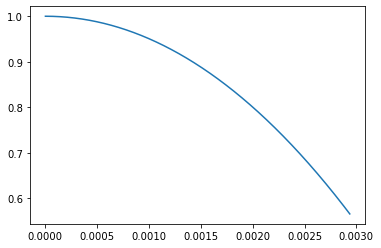

In [829]:
#position
fig, ax = plt.subplots()

# extract axes from position list
pos_x = list(map(lambda xy: xy[0], pos))
pos_y = list(map(lambda xy: xy[1], pos))

ax.plot(pos_x, pos_y)

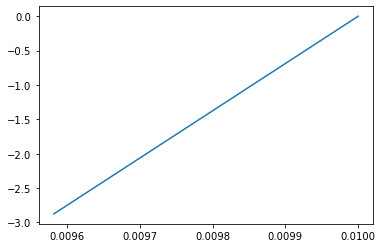

In [830]:
#velocity
fig, ax = plt.subplots()

# extract axes from position list
v_x = list(map(lambda xy: xy[0], v))
v_y = list(map(lambda xy: xy[1], v))

ax.plot(v_x, v_y)

In [831]:
# overflow error leading to straight path starts at particle size 1e-6

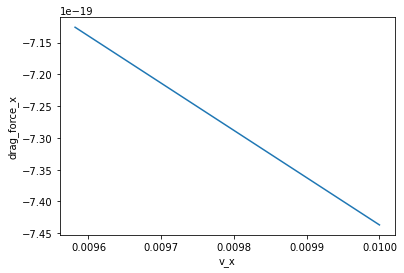

In [832]:
#drag_forces x
fig, ax = plt.subplots()

# extract axes from position list

v_x = list(map(lambda xy: xy[0], v))
drag_forces_x.append(drag_forces_x[len(drag_forces_x) - 1])
plt.xlabel('v_x')
plt.ylabel('drag_force_x')
ax.plot(v_x, drag_forces_x)

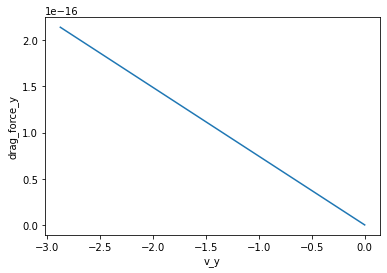

In [833]:
#drag_forces y
fig, ax = plt.subplots()

# extract axes from position list

v_y = list(map(lambda xy: xy[1], v))
drag_forces_y.append(drag_forces_y[len(drag_forces_y) - 1])
plt.xlabel('v_y')
plt.ylabel('drag_force_y')
ax.plot(v_y, drag_forces_y)